In [1]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
import functools
from IPython.display import clear_output
import datetime as dt
import random
import itertools
from mpl_toolkits.basemap import Basemap
from salishsea_tools import geo_tools, geo_tools, tidetools, data_tools

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [2]:
# converts lons/lats like this "124° 01.400" to decimal format
def strLonLatToDec(lstr):
    if type(lstr) is not str:
        return(np.NaN)
    lstr = lstr.replace(u'°',' ')
    lstr = lstr.split()
    return (int(lstr[0])+float(lstr[1])/60.0)

In [3]:
# Grab tracer data

#  '/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPedit.xls'
tracer_df = pd.read_excel('/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPeditfinal.xls')
tracer_df = tracer_df[~pd.isnull(tracer_df["Date"])]
#tracer_df["Date"] = pd.to_datetime(tracer_df["Date"])
tracer_df = tracer_df.sort_values("Date")
tracer_df["DECIMAL_LON"] = (tracer_df["Longitude"].apply(strLonLatToDec))*(-1)
tracer_df["DECIMAL_LAT"] = (tracer_df["Latitude"].apply(strLonLatToDec))
tracer_df["STATION_LAT"] =  tracer_df.groupby("Station ID")["DECIMAL_LAT"].transform(np.median)
tracer_df["STATION_LON"] =  tracer_df.groupby("Station ID")["DECIMAL_LON"].transform(np.median)

In [4]:
# Create smaller dataframe with location of stations
station_lon_lat = tracer_df[["Station ID", "STATION_LON", "STATION_LAT"]].drop_duplicates()
station_lon_lat.columns = ["STATION", "LON", "LAT"]

# Add corresponding model points to station data frame
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

def closest_model_point_wrapper(lon, lat):
    try:
        model_point = geo_tools.find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
        return(model_point)
    except:
        print("ERROR" + str(lon) + " " + str(lat))
        return(np.nan)
    
station_lon_lat["MODEL_POINT"] = station_lon_lat.apply(lambda row: closest_model_point_wrapper(row[1], row[2]) , axis = 1)
station_lon_lat["MODEL_J"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[0])
station_lon_lat["MODEL_I"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[1])

In [5]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd

mat = loadmat('/ocean/jylam/Final/2015/PSF_CWBstn.mat')  # load mat-file
mdata = mat['PSFc']  # variable in mat file

ndata = {n: mdata[n][0, 0] for n in mdata.dtype.names}

for key in ndata.keys():
    if ndata[key].shape == (400, 2054):
        ndata[key] = ndata[key].ravel()
    elif ndata[key].shape == (1, 2054):
        ndata[key] = np.tile(ndata[key],400).ravel()
    else:
        print("what")
all_ts_df = pd.DataFrame(ndata)

In [6]:
patrol_num_name = {1 : "LD", 2 : "PR", 3 : "IS", 4 : "BS", 5 : "NQ", 6 : "CR", 8 : "SV", 9 : "VC", 10 : "CWB"}
def get_station_name(patrol_num, station_num):
    station_name = None
    patrol_name = patrol_num_name[patrol_num]
    if patrol_name == "CWB":
        if station_num == 5:
           station_name = "CBW2"
        elif station_num ==7:
           station_name = "CBC1"
        elif station_num ==8:
           station_name = "CBC2"
        elif station_num ==9: 
           station_name = "CBC3"
        elif station_num ==11:
           station_name = "CBE2"
    else:
        station_name = patrol_name + str(station_num)
    return(station_name)

all_ts_df["STATION_NAME"] = all_ts_df.apply(lambda row: get_station_name(int(row["patrol"]), int(row["stnN"])), axis = 1)
all_ts_df = all_ts_df[~pd.isnull(all_ts_df["mtimes"])]
all_ts_df["DATE"] = all_ts_df.mtimes.apply(lambda mt: dt.datetime.fromordinal(int(mt)) + dt.timedelta(days=mt%1) - dt.timedelta(days = 366))

In [7]:
ts_df = all_ts_df[["STATION_NAME", "DATE","long", "lat", "depth", "sal", "temp"]]
ts_df.columns = ["STATION", "DATE", "LON", "LAT", "DEPTH", "SAL", "TEMP"]
ts_df["DATA_TYPE"] = "Measured"
ts_df["DAY_OF_YEAR"] = ts_df["DATE"].apply(lambda x: x.dayofyear)

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# Choose which values to add to nowcast dataframe

tracers = ["votemper", "vosaline"]

months = ["feb", "mar", "apr", "may", "jun", "jul", "aug", "sep"]

hours = np.array([12])

max_depth = 60
result_depths = xr.open_dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/deptht_428m.nc').deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

station_points = station_lon_lat["MODEL_POINT"]
station_names = station_lon_lat["STATION"]

stations = dict(zip(station_names, station_points))

nowcast_df = pd.read_pickle("/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/station_ts_feb-sep.pkl")
#nowcast_df["DATE"] = pd.to_datetime(nowcast_df["DATE"], infer_datetime_format=True)
#nowcast_df = data_tools.load_nowcast_station_tracers(tracers, stations, months, hours, depth_indices, file_ending = "grid_T.nc", save_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/station_ts_feb-sep.pkl")

In [9]:
nowcast_df["SALINITY"] = nowcast_df["vosaline"]
nowcast_df["TEMPERATURE"] = nowcast_df["votemper"]
ts_df["SALINITY"] = ts_df["SAL"]
ts_df["TEMPERATURE"] = ts_df["TEMP"]

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
nowcast_df["DAY_OF_YEAR"] = nowcast_df["DATE"].apply(lambda x: x.dayofyear)
nowcast_df["DATA_TYPE"] = "Nowcast"
combined = pd.concat([ts_df.query("(DEPTH - 0.75)**2 < 0.0001 | (DEPTH - 19.75)**2 < 0.0001"), nowcast_df.query("(DEPTH - 0.500011)**2 < 0.0001 | (DEPTH - 19.481785)**2 < 0.0001")])
combined["IDENTIFIER"] = combined["DATA_TYPE"] + ", Depth = " + combined["DEPTH"].apply(str)
combined.STATION = combined.STATION.apply(lambda x: x.strip() if x is not None else x)
combined = combined.sort_values(["STATION", "DATE"])

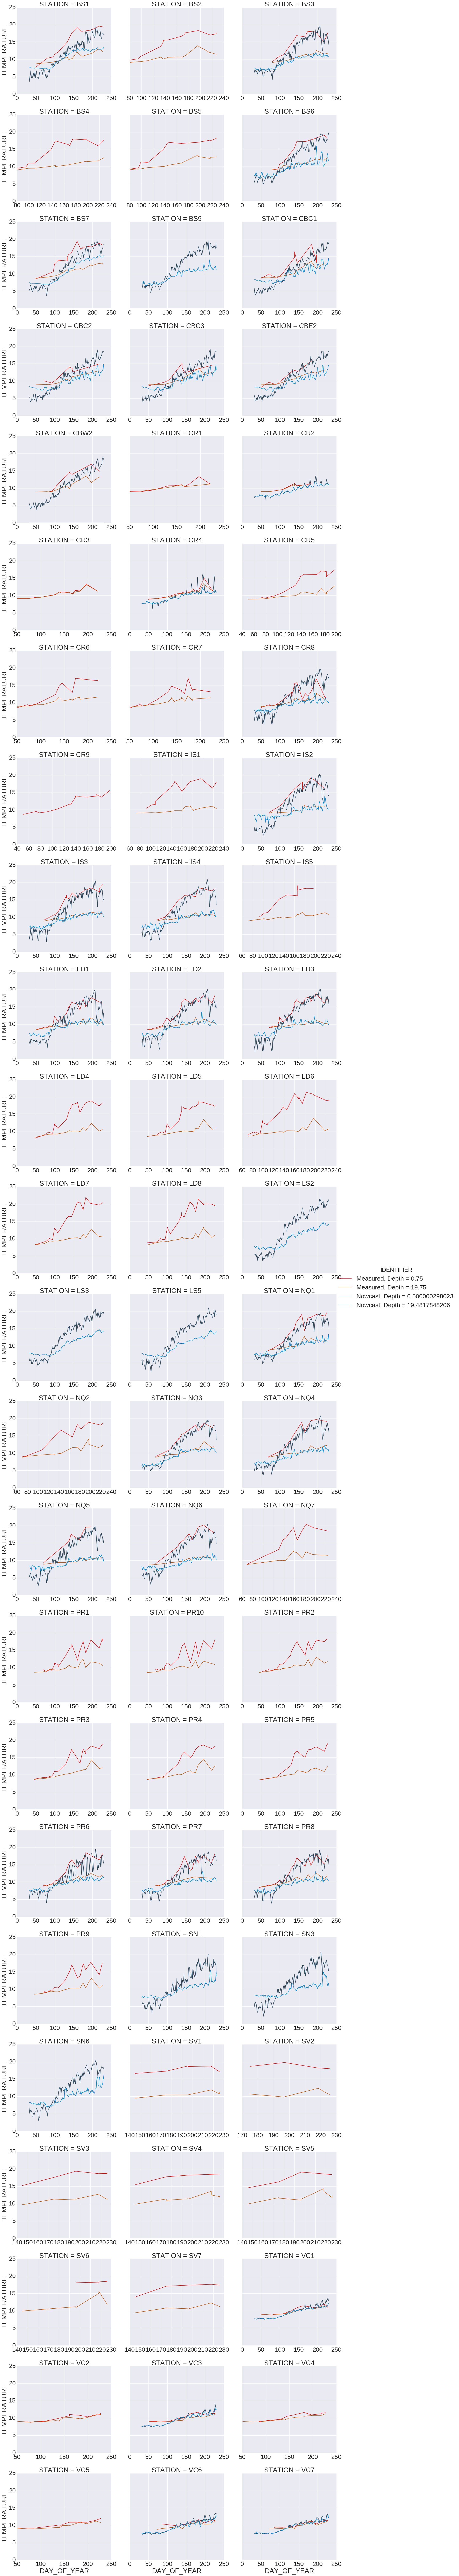

In [12]:
# Temperature

colors = ["red","burnt orange", "dark grey blue", "cerulean",]
cmap = sns.xkcd_palette(colors)

sns.set(font_scale = 3)
fg = sns.FacetGrid(data = combined[(combined["DAY_OF_YEAR"] <= max(nowcast_df["DAY_OF_YEAR"]))], col = "STATION", col_wrap=3, hue = "IDENTIFIER", size =8, sharex = False, sharey = True, palette= cmap)
fg.map(plt.plot,"DAY_OF_YEAR", "TEMPERATURE").add_legend()
#plt.xticks(rotation=45)
plt.subplots_adjust(top=0.9)

In [57]:
combined_all_depths = pd.concat([ts_df, nowcast_df])
combined_all_depths["DATE_STR"] = combined_all_depths["DATE"].apply(lambda x: x.strftime('%Y-%m-%d'))
combined_all_depths["IDENTIFIER"] = combined_all_depths["DATA_TYPE"] + ", Date = " + combined_all_depths["DATE_STR"]
combined_all_depths.STATION = combined_all_depths.STATION.apply(lambda x: x.strip() if x is not None else x)
combined_all_depths = combined_all_depths.sort_values(["STATION", "DATE"])

In [58]:
combined_all_depths

DATA_TYPE                       DATE  DAY_OF_YEAR  DEPTH  HOUR  \
847     Measured 2015-02-18 23:08:10.346147           49   0.75   NaN   
2901    Measured 2015-02-18 23:08:12.000010           49   1.25   NaN   
4955    Measured 2015-02-18 23:08:12.916662           49   1.75   NaN   
7009    Measured 2015-02-18 23:08:13.916667           49   2.25   NaN   
9063    Measured 2015-02-18 23:08:14.999994           49   2.75   NaN   
11117   Measured 2015-02-18 23:08:16.083331           49   3.25   NaN   
13171   Measured 2015-02-18 23:08:17.166719           49   3.75   NaN   
15225   Measured 2015-02-18 23:08:18.250007           49   4.25   NaN   
17279   Measured 2015-02-18 23:08:19.416637           49   4.75   NaN   
19333   Measured 2015-02-18 23:08:20.583337           49   5.25   NaN   
21387   Measured 2015-02-18 23:08:21.583332           49   5.75   NaN   
23441   Measured 2015-02-18 23:08:22.666720           49   6.25   NaN   
25495   Measured 2015-02-18 23:08:23.666604           49   6.75   NaN   
27549   Measured 2015-02-18 23:08:24.583326           49   7.25   NaN   
29603   Measured 2015-02-18 23:08:25.583340           49   7.75   NaN   
31657   Measured 2015-02-18 23:08:26.500002           49   8.25   NaN   
33711   Measured 2015-02-18 23:08:27.416664           49   8.75   NaN   
35765   Measured 2015-02-18 23:08:28.333406           49   9.25   NaN   
37819   Measured 2015-02-18 23:08:29.166604           49   9.75   NaN   
39873   Measured 2015-02-18 23:08:30.083336           49  10.25   NaN   
41927   Measured 2015-02-18 23:08:31.083331           49  10.75   NaN   
43981   Measured 2015-02-18 23:08:31.999992           49  11.25   NaN   
46035   Measured 2015-02-18 23:08:32.916674           49  11.75   NaN   
48089   Measured 2015-02-18 23:08:33.916669           49  12.25   NaN   
50143   Measured 2015-02-18 23:08:34.916663           49  12.75   NaN   
52197   Measured 2015-02-18 23:08:35.900001           49  13.25   NaN   
54251   Measured 2015-02-18 23:08:37.000005           49  13.75   NaN   
56305   Measured 2015-02-18 23:08:38.000000           49  14.25   NaN   
58359   Measured 2015-02-18 23:08:38.916662           49  14.75   NaN   
60413   Measured 2015-02-18 23:08:39.999999           49  15.25   NaN   
...          ...                        ...          ...    ...   ...   
133505  Measured 2015-09-16 17:40:04.666602          259  32.75   NaN   
2052    Measured 2015-09-16 17:58:23.966604          259   0.75   NaN   
4106    Measured 2015-09-16 17:58:24.833407          259   1.25   NaN   
6160    Measured 2015-09-16 17:58:25.750008          259   1.75   NaN   
8214    Measured 2015-09-16 17:58:26.750013          259   2.25   NaN   
10268   Measured 2015-09-16 17:58:27.833280          259   2.75   NaN   
12322   Measured 2015-09-16 17:58:29.083374          259   3.25   NaN   
14376   Measured 2015-09-16 17:58:30.333287          259   3.75   NaN   
16430   Measured 2015-09-16 17:58:31.416684          259   4.25   NaN   
18484   Measured 2015-09-16 17:58:32.500002          259   4.75   NaN   
20538   Measured 2015-09-16 17:58:33.750005          259   5.25   NaN   
22592   Measured 2015-09-16 17:58:34.916665          259   5.75   NaN   
24646   Measured 2015-09-16 17:58:35.916680          259   6.25   NaN   
26700   Measured 2015-09-16 17:58:36.916655          259   6.75   NaN   
28754   Measured 2015-09-16 17:58:37.916669          259   7.25   NaN   
30808   Measured 2015-09-16 17:58:38.916664          259   7.75   NaN   
32862   Measured 2015-09-16 17:58:40.000001          259   8.25   NaN   
34916   Measured 2015-09-16 17:58:40.999996          259   8.75   NaN   
36970   Measured 2015-09-16 17:58:41.916668          259   9.25   NaN   
39024   Measured 2015-09-16 17:58:43.000005          259   9.75   NaN   
41078   Measured 2015-09-16 17:58:43.999990          259  10.25   NaN   
43132   Measured 2015-09-16 17:58:44.833409          259  10.75   NaN   
45186   Measured 2015-09-16 17:58:45.749990          259  11.25  

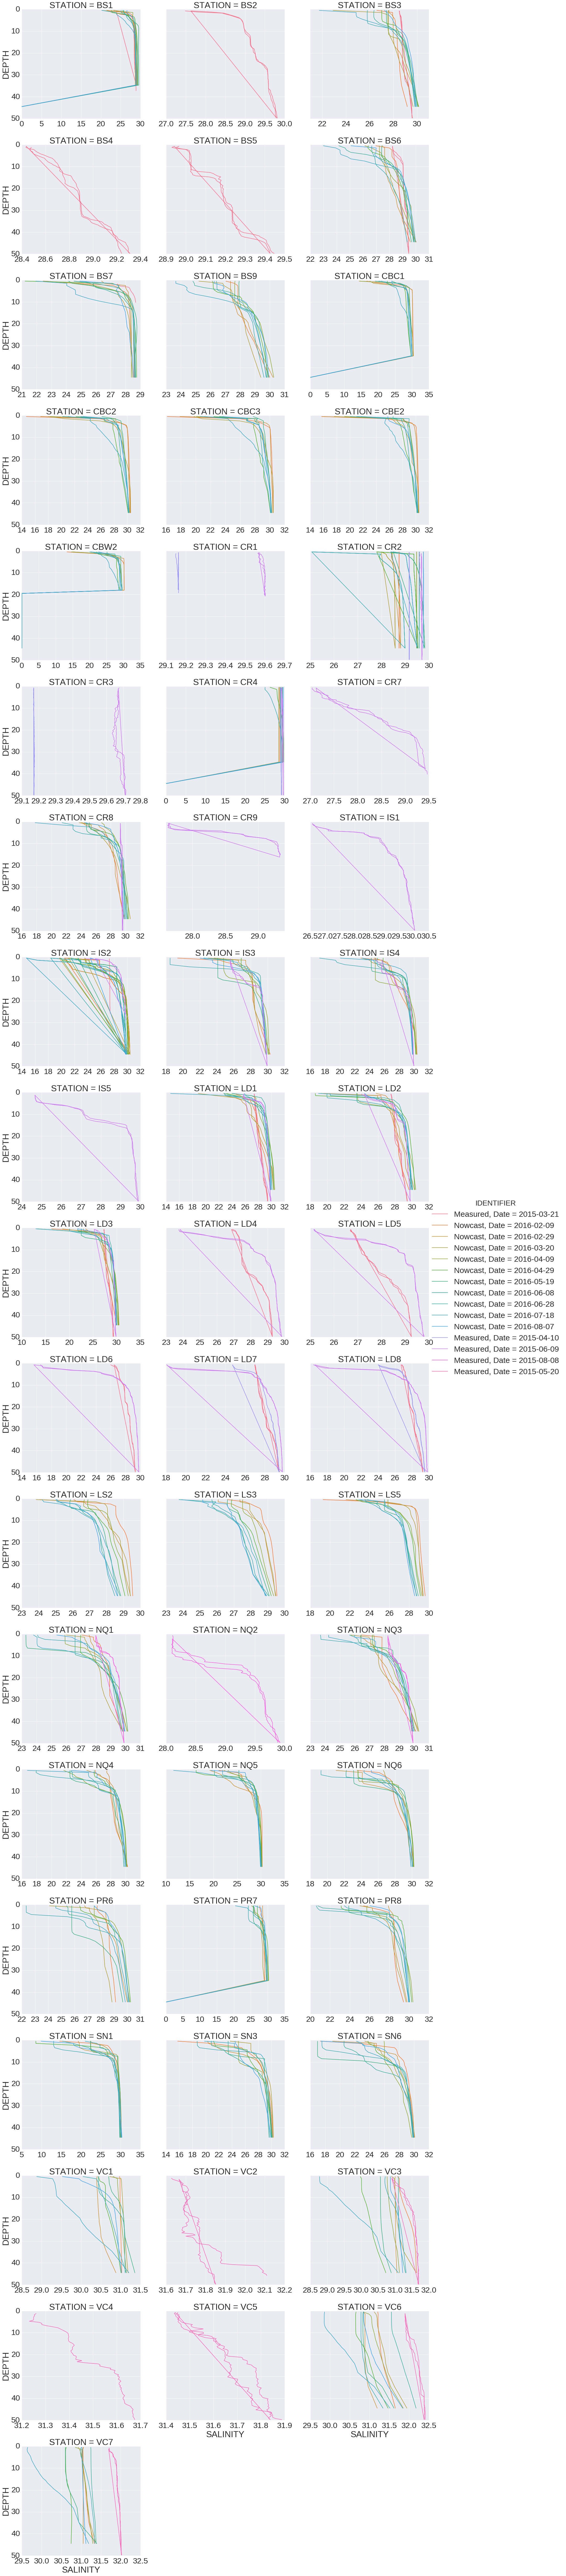

In [67]:
# Temperature depth profiles



sns.set(font_scale = 3)
fg = sns.FacetGrid(data = combined_all_depths[(combined_all_depths["DAY_OF_YEAR"] <= max(nowcast_df["DAY_OF_YEAR"])) & 
                                              ( (combined_all_depths["DAY_OF_YEAR"]%20 == 0)) & #(combined_all_depths["DATA_TYPE"] == "Measured") |
                                              (combined_all_depths["DEPTH"] < 50)
                          ], 
                   col = "STATION", col_wrap=3, hue = "IDENTIFIER", size =8, sharex = False, sharey = True)
fg.map(plt.plot,"SALINITY", "DEPTH").add_legend()
#plt.xticks(rotation=45)
plt.subplots_adjust(top=0.9)
plt.gca().invert_yaxis()

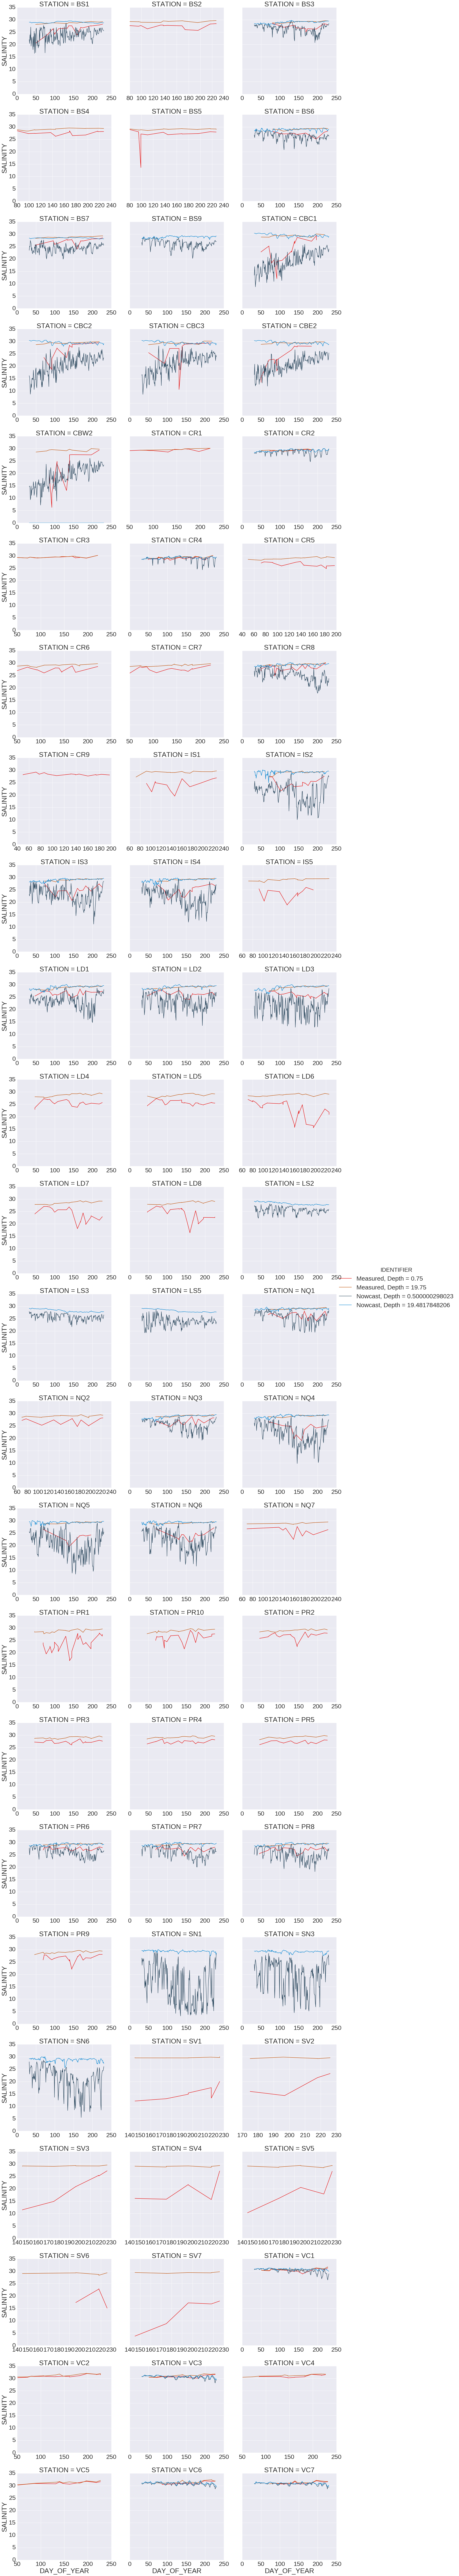

In [13]:
#Salinity

colors = ["red","burnt orange", "dark grey blue", "cerulean",]
cmap = sns.xkcd_palette(colors)

sns.set(font_scale = 3)
fg = sns.FacetGrid(data = combined[(combined["DAY_OF_YEAR"] <= max(nowcast_df["DAY_OF_YEAR"]))], col = "STATION", col_wrap=3, hue = "IDENTIFIER", size =8, sharex = False, sharey = True, palette= cmap)
fg.map(plt.plot,"DAY_OF_YEAR", "SALINITY").add_legend()
#plt.xticks(rotation=45)
plt.subplots_adjust(top=0.9)

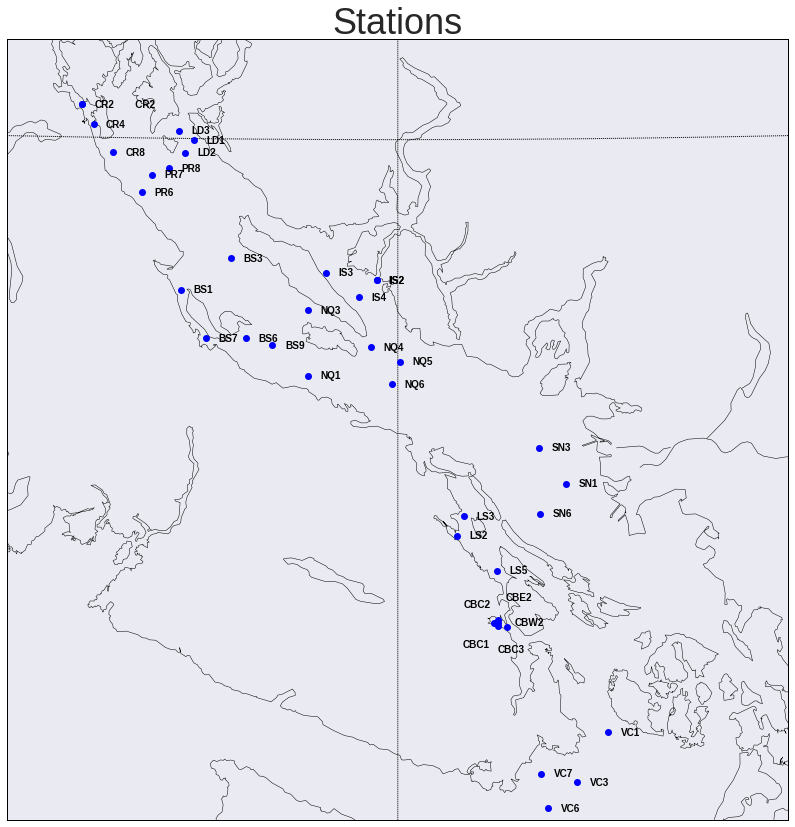

In [53]:
# get unique stations and map them

# map:
width = 225000; lon_0 = -124.0; lat_0 = 49.25
plt.figure(figsize=(14,14))
m = Basemap(width=width,height=width,projection='aeqd', resolution='h',
            lat_0=lat_0,lon_0=lon_0)
# fill background.
m.drawmapboundary()
# draw coasts and fill continents.
m.drawcoastlines(linewidth=0.5)
m.drawrivers()
#m.shadedrelief()
# 20 degree graticule.
m.drawparallels(np.arange(40,60,2))
m.drawmeridians(np.arange(-130,-110,2))
plt.title('Stations')

cb_count = 0
# map stations:
for index, row in station_lon_lat.iterrows():
    name = row["STATION"]
    lon = row["LON"]
    lat = row["LAT"]
    xpt, ypt = m(lon, lat)
    xpt2, ypt2 = m(lon+.05, lat)
    if re.search('CB',name):
        xpt2, ypt2 = m(lon+np.cos(cb_count*2.0*np.pi/5.0)*.12 - 0.04, lat+np.sin(cb_count*2.0*np.pi/5.0)*0.08)
        cb_count = cb_count + 1

    m.plot([xpt],[ypt],'bo')
    plt.text(xpt2,ypt2,name,fontsize=10,fontweight='bold',
                    ha='left',va='center',color='k')